# Procesamiento de Imagenes Satelitales Landsat 8 OLI LASRC

Las scenas **Landsat 8 OLI LASRC** tomadas en este trabajo, son imágenes pertenecientes a la Colección 1 - Nivel 2 (On demand) del catálogo de imagenes USGS Earth Explorer. Las imagenes del Nivel 2 presentan correcciones atmosfericas de reflectancia de superficie (Surface Reflectance SR). Estas correcciones mitigan el efecto de los gases o aerosoles que se encuentran en la atmosfera y pueden afectar la reflectancia de la tierra sensada por el satelite (sensor). Las correcciones atmosféricas son llevadas a cabo por el algoritmo LASRC (Landsat Surface Reflectance Code)

Durante la generación de las scenas corregidas en superficie de reflectancia, el algoritmo LASRC evalua la calidad de cada pixel y esta información la información de esta evaluación la registra en 3 bandas (**sr_aeroso**, **pixel_qa**, **radsat_qa**) que se generan de forma adicional al finalizar la corección de reflectancia.


## Referencias
1. [Designación de Bandas para Satelites Landsat](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products)
2. [Evaluación de la Calidad de los Pixeles en Landsat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8-surface-reflectance-quality-assessment?qt-science_support_page_related_con=1#qt-science_support_page_related_con)
3. [Lansat Surface Reflectance Code (LASRC) Product Guide](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf) - Cloud Mask

In [3]:
%matplotlib inline

import numpy as np
import xarray as xr
import rasterio as rio

import os
import glob
import tarfile
import shutil
import datacube

from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask

In [ ]:
# path = "./data/"
# img_folder_list = os.listdir(path)
# img_folder_list
# for img_folder in img_folder_list:
#     img_list = os.listdir(path+img_folder+"/")
#     for img in img_list:
#         sat_img = xr.open_rasterio(path+img_folder+"/"+img)
#         xr_img_dataset = da.to_dataset(name="img_table1")
#         show(sat_img)

# def get_tar_gz_files(folder_path):
# tar_gz_files = glob.glob('../data/*.tar.gz')

# def untar(tar_file_path)
#     dst = tar_file_path.replace('.tar.gz','')
#     tf = tarfile.open(tar_file_path)
#     tf.extractall(path=dst)
#     return dst

# def remove_dir(dir_path):
#     """
#     Elimina únicamente directorios que contengan 
#     scenas landsat 8.
#     """
#     if 'LC080' in dir_path:
#         shutil. rmtree(dir_path)

# def get_band_dataset(tiff_file_path):

In [ ]:
tif_path = 'data/LC080100562018011001T1-SC20191101092114/LC08_L1TP_010056_20180110_20180119_01_T1_pixel_qa.tif'

sat_img = xr.open_rasterio(tif_path)
show(sat_img)

In [ ]:
# Se pierden los datos de localización
xr_img_dataset = sat_img.to_dataset(name="img_table1")
xr_img_dataset.img_table1.plot()

In [4]:
dc = datacube.Datacube(app="Query")

xarr = dc.load(
    product="LS8_OLI_LASRC",
    latitude=(3,5),
    longitude=(-78, -76), 
    # Time format YYYY-MM-DD
    time=("2018-01-01","2018-12-31"), 
    measurements=['blue','green','red','swir1','swir2','pixel_qa']
)

xarr

<xarray.Dataset>
Dimensions:    (latitude: 7373, longitude: 7409, time: 4)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-10T15:24:47 2018-01-10T15:25:11 ...
  * latitude   (latitude) float64 5.0 5.0 4.999 4.999 4.999 4.999 4.998 ...
  * longitude  (longitude) float64 -78.0 -78.0 -78.0 -78.0 -78.0 -78.0 -78.0 ...
Data variables:
    blue       (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    green      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    red        (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    swir1      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    swir2      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    pixel_qa   (time, latitude, longitude) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    crs:      EPSG:4326

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2543814e18> (for post_execute):


MemoryError: Unable to allocate array with shape (54626557, 4) and data type float64

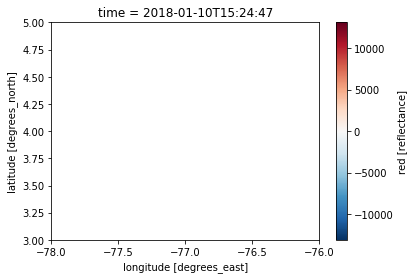

In [7]:
xarr.red[0].plot()

## Limpieza de datos

Para optimizar el entrenamiento y el testeo de los datos se cambia el valor de todo pixel con nubes a 9999. De esta forma, el pixel es excluido del entrenamiento y el testeo de los modelos. Esto permite reducir la cantidad de datos a solo las characteristicas del suelo y el agua. Se realiza este filtrado utilizando el mapa de nubes ofrecido por USGS presente en la banda 

## Mascara de Nubes

Al momento de tomar la scena de la tierra, pueden presentarse nubes que obstruyen la vista del sensor (satelite). Estas nubes 

### Referencias
1. [Clean Remote Sensing Data in Python - Clouds, Shadows & Cloud Masks](https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-modis/cloud-masks-with-spectral-data-python/)

In [ ]:
def cloud_mask(dataset,product):

    # PIXEL_QA VALUES TO BE MASKED (IDEAM) 
    clear = [322, 386, 834, 898, 1346]
    water = [324, 388, 836, 900, 1348]
    valid_values = clear + water
    
    # PIXEL_QA VALUES TO BE MASKED (References)
#     clear = [322, 386, 834, 898, 1346]
#     cloud_shadow = [328, 392, 840, 904, 1350]
#     cloud = [352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
#     high_confidence_cloud = [480, 992]
#     valid_values = clear + cloud_shadow + cloud + high_confidence_cloud
    
    cloud_mask = np.isin(dataset["pixel_qa"].values, valid_values)

    for band in bands:
        xarr0[band].values = np.where(np.logical_and(xarr0.data_vars[band] != nodata, cloud_mask), xarr0.data_vars[band],nodata).astype(np.int16)
    output = xarr0